#Library Packages

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19


from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

#Data Acquisition

#Data Exploration

###Data Understanding

In [ ]:
basedir = "./DATASET/"
traindir= "./DATASET/TRAIN/"
testdir = "./DATASET/TEST/"

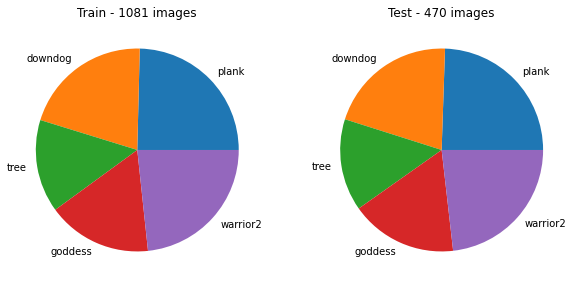

In [ ]:
class_names = []
train_dist = []
test_dist = []
train_counts = []
test_counts = []

# for train
for dir in os.listdir(traindir):
    class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(traindir+dir+'/')) # count the files on the dir
    train_dist.append(number) # append that number
    image_count = 0
    for img in os.listdir(os.path.join(traindir,dir)):
      image_count +=1
    train_counts.append(image_count)
    
# for test
for dir in os.listdir(testdir):
    #class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(testdir+dir+'/')) # count the files on the dir
    test_dist.append(number) # append that number
    image_count = 0
    for img in os.listdir(os.path.join(testdir,dir)):
      image_count +=1
    test_counts.append(image_count)


plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(train_dist, labels=class_names)
plt.title(f'Train - {sum(train_dist)} images')
plt.subplot(1,2,2)
plt.pie(test_dist, labels=class_names)
plt.title(f'Test - {sum(test_dist)} images')
plt.show()

In [ ]:
#Train
print(class_names)
print(train_counts)

['plank', 'downdog', 'tree', 'goddess', 'warrior2']
[266, 223, 160, 180, 252]


In [ ]:
#Test
print(class_names)
print(test_counts)

['plank', 'downdog', 'tree', 'goddess', 'warrior2']
[115, 97, 69, 80, 109]


###Data Prepocessing & Image Augmentation

In [ ]:
# set the random seed
tf.keras.backend.clear_session()
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# instance and adjust the options
train_datagen = ImageDataGenerator(
    rescale = 1/255, # normalize the values
    shear_range = 0.2, # it means to cut the image
    zoom_range = 0.2, # make zoom
    horizontal_flip = True # invert horizontally
)

test_datagen = ImageDataGenerator(
    rescale = 1/ 255,
    horizontal_flip = True,
    validation_split=0.25, # this is going to be for val
)

In [ ]:
image_size = 128

# and load the images
train_gen = train_datagen.flow_from_directory(
    traindir, # the data folder
    batch_size = 16,
    class_mode = 'categorical', # for multi class
    target_size = (image_size, image_size), # the image size
    shuffle = True,
    seed = 42
)

# test, and i will use some of these images for validation
test_gen = test_datagen.flow_from_directory(
    testdir, # the data folder
    batch_size = 16,
    class_mode = 'categorical', # for multi class
    target_size = (image_size, image_size), # the image size
    shuffle = True,
    seed = seed,
    subset='training', # since test will be bigger than val
)

# now validation
val_gen = test_datagen.flow_from_directory(
    testdir, 
    batch_size = 16,
    class_mode = 'categorical', 
    target_size = (image_size, image_size), 
    shuffle = True,
    seed = seed,
    subset='validation', 
)

Found 1081 images belonging to 5 classes.
Found 354 images belonging to 5 classes.
Found 116 images belonging to 5 classes.


In [ ]:
class_weights = []
total_samples = train_gen.samples
total_classes = len(train_gen.class_indices)
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)

class_weights = dict(zip(train_gen.class_indices.values(),class_weights))
print(class_weights)

{0: 0.81, 1: 0.97, 2: 1.35, 3: 1.2, 4: 0.86}


#VGG19-Model

In [ ]:
def custom_model():
    
    
    cus_model = VGG19(input_shape = (150,150,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = layers.Flatten()(cus_model.output)

    x = layers.Dense(512, activation='relu')(x)
    
    x = layers.Dropout(0.2)(x)
 
    x = layers.Dense(5, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

In [ ]:
model = custom_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Checkpoint callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint("yoga_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=30,
                    batch_size=32,
                    callbacks=[lr_scheduler_ed, early_stopping_m],
                    verbose=1
                    )

Epoch 1/30
 4/68 [>.............................] - ETA: 3:23 - loss: 4.4364 - accuracy: 0.2812

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


68/68 [==============================] - 251s 4s/step - loss: 1.2950 - accuracy: 0.5948 - val_loss: 0.2321 - val_accuracy: 0.9310 - lr: 9.0000e-04
Epoch 2/30
68/68 [==============================] - 248s 4s/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.1103 - val_accuracy: 0.9655 - lr: 5.6786e-04
Epoch 3/30
68/68 [==============================] - 250s 4s/step - loss: 0.3960 - accuracy: 0.8760 - val_loss: 0.0980 - val_accuracy: 0.9741 - lr: 3.5830e-04
Epoch 4/30
68/68 [==============================] - 250s 4s/step - loss: 0.3050 - accuracy: 0.9093 - val_loss: 0.0747 - val_accuracy: 0.9914 - lr: 2.2607e-04
Epoch 5/30
68/68 [==============================] - 254s 4s/step - loss: 0.2765 - accuracy: 0.9288 - val_loss: 0.0796 - val_accuracy: 0.9741 - lr: 1.4264e-04
Epoch 6/30
68/68 [==============================] - 252s 4s/step - loss: 0.2401 - accuracy: 0.9352 - val_loss: 0.0888 - val_accuracy: 0.9655 - lr: 9.0000e-05
Epoch 7/30
68/68 [==============================] - 251s 4s/ste

<Figure size 432x288 with 0 Axes>

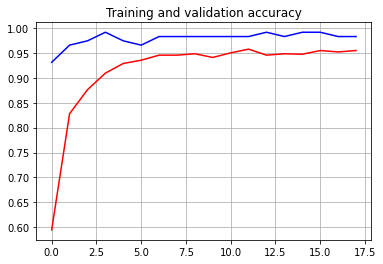

<Figure size 432x288 with 0 Axes>

In [ ]:
#Graph betweet training accuracy & validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

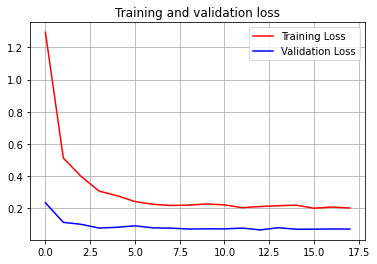

In [ ]:
#Graph between training loss & validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

(0.0, 1.0)

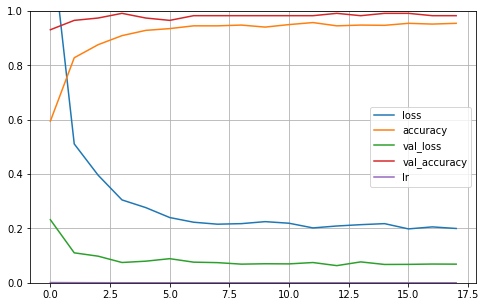

In [ ]:
#in one graph
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [ ]:
model.save('yogamodel.h5')

In [ ]:
loaded_model = keras.models.load_model('./yogamodel.h5')
model = loaded_model

#Evaluation

In [ ]:
# with data test
results = model.evaluate(test_gen, batch_size=1)
print("test loss, test acc:", results)

19/23 [=======================>......] - ETA: 15s - loss: 0.1787 - accuracy: 0.9474

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


23/23 [==============================] - 83s 4s/step - loss: 0.1710 - accuracy: 0.9492
test loss, test acc: [0.17103058099746704, 0.9491525292396545]


In [ ]:
# confusion matrix
from sklearn.metrics import classification_report

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_gen.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


              precision    recall  f1-score   support

           0       0.29      0.29      0.29        73
           1       0.12      0.12      0.12        60
           2       0.33      0.34      0.34        87
           3       0.25      0.25      0.25        52
           4       0.27      0.27      0.27        82

    accuracy                           0.26       354
   macro avg       0.25      0.25      0.25       354
weighted avg       0.26      0.26      0.26       354



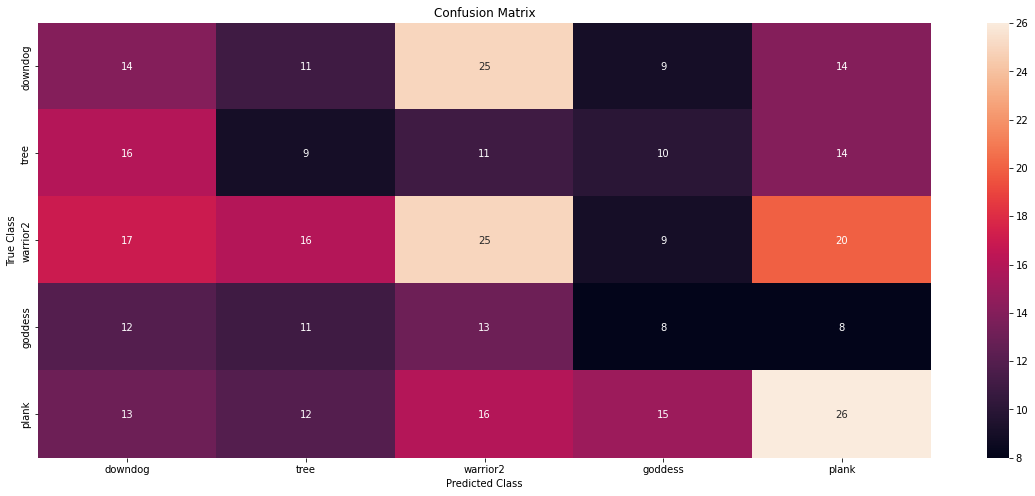

In [ ]:
cf_matrix = confusion_matrix(test_gen.classes, y_pred)
Labels = ['downdog', 'tree', 'warrior2', 'goddess', 'plank']
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## TFLite Import

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

yoga_final_model_name = "YogaTFLite_Model.tflite"

tflite_model_name = yoga_final_model_name
open(tflite_model_name,"wb").write(tflite_model)

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
    
convert_bytes(get_file_size(tflite_model_name),"MB")

INFO:tensorflow:Assets written to: /tmp/tmp05sec0vr/assets


File size: 92.408 Megabytes


In [ ]:
yoga_labels = {0:"downdog",1:"goddess",2:"plank",3:"tree",4:"warrior2"} 

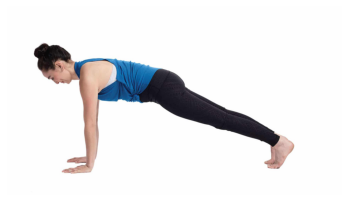

Class Predictions:  [[0. 0. 1. 0. 0.]]

Prediction is:  plank


In [ ]:
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg

# predicting images
path = "/content/yoga-poses-dataset/DATASET/TEST/plank/00000000.jpg"

img = image.load_img(path, target_size=(128, 128))
x = image.img_to_array(img)
# print(x/255)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print("Class Predictions: ",classes)
pred_index = np.argmax(classes[0])
print("\nPrediction is: ", yoga_labels[pred_index])

Enter Image Name (from 1-15) : 12


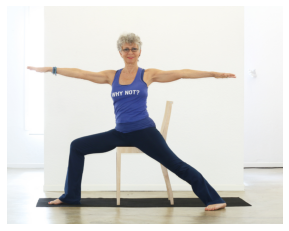

Class Predictions:  [[0. 0. 0. 0. 1.]]

Prediction is:  warrior2


In [ ]:
# predicting images
path = input("Enter Image Name (from 1-15) : ")
path = "/content/drive/MyDrive/Orbit Future Academy/Project Akhir/klasifikasi model mayan:)/dataset_yoga_final/" + path + ".jpg"

img = image.load_img(path, target_size=(128, 128))
x = image.img_to_array(img)
# print(x/255)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = loaded_model.predict(images, batch_size=10)

plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print("Class Predictions: ",classes)
pred_index = np.argmax(classes[0])
print("\nPrediction is: ", yoga_labels[pred_index])